In [7]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from tensorflow.keras.utils import plot_model

# 1. Autism Spectrum: Adult Dataset

In [226]:
# Import Data
df = pd.read_csv('/autism_screening.csv')

## I. Data Preprocessing

In [227]:
# Checking for the target variable distribution
fig = px.pie(data_frame = df, names = 'austim', hole = 0.5, title = 'Yes vs No', 
             width = 640, height = 480, color_discrete_sequence = px.colors.sequential.Bluered)
fig.update_layout(title_x = 0.5, uniformtext_minsize = 30)
fig.show()

<ipython-input-228-93ddb8500e40>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



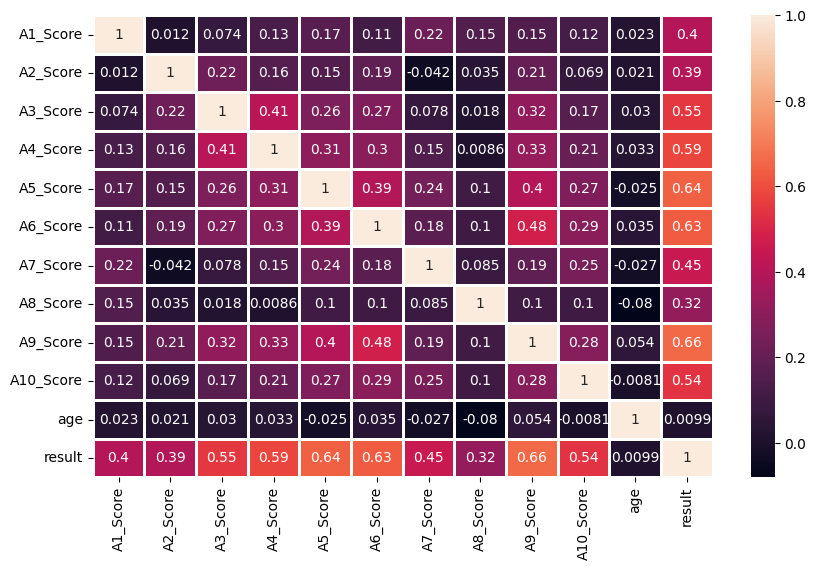

In [228]:
#Correlation plot
plt.figure(figsize = (10, 6))

corr = df.corr()

sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

In [9]:
df = df.dropna(subset=['age'])

In [10]:
df['austim'] = df['austim'].map({'yes': 1, 'no': 0})

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()

print(missing_values)

In [12]:
# Specify the column and the string to count
column_name = ['ethnicity', 'relation','age']
string_to_count = '?'

# Count the occurrences of the string in the column
for i in column_name:
  count = (df[i] == string_to_count).sum()
  print(count)

93
93
0


In [13]:
column_name = 'ethnicity'
column_name2 = 'relation'

mode_value = df[column_name].mode()[0]
mode_value2 = df[column_name].mode()[0]

# Replace the specific string with the mode of the column
df.ethnicity = df.ethnicity.replace('?', mode_value)
df.age = df.age.replace('?', mode_value)
df.relation = df.relation.replace('others', 'Others')
df.ethnicity = df.ethnicity.replace('others', 'Others')
df.relation = df.relation.replace('?', mode_value)
df.ethnicity = df.ethnicity.replace("'Middle Eastern '", 'Middle Eastern' )
df.ethnicity = df.ethnicity.replace('Middle Eastern ','Middle Eastern')
df.ethnicity = df.ethnicity.replace("'South Asian'",'South Asian')
df.relation = df.relation.replace("'Health care professional'", 'Health care professional')
df.relation = df.relation.replace('self', 'Self')
df.age_desc = df.age_desc.replace("'12-15 years'", "'12-16 years'")

In [14]:
# Split the dataset into features and target variable
X = df.drop('austim', axis=1)
y = df['austim']

In [15]:
X = X.drop(columns=['age','result','contry_of_res','Class/ASD'])

In [16]:
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['ethnicity','relation','gender','jundice','used_app_before','age_desc'])

In [17]:
X = X.astype(int)

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702 entries, 0 to 703
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   A1_Score                           702 non-null    int64
 1   A2_Score                           702 non-null    int64
 2   A3_Score                           702 non-null    int64
 3   A4_Score                           702 non-null    int64
 4   A5_Score                           702 non-null    int64
 5   A6_Score                           702 non-null    int64
 6   A7_Score                           702 non-null    int64
 7   A8_Score                           702 non-null    int64
 8   A9_Score                           702 non-null    int64
 9   A10_Score                          702 non-null    int64
 10  ethnicity_Asian                    702 non-null    int64
 11  ethnicity_Black                    702 non-null    int64
 12  ethnicity_Hispanic    

In [19]:
# Random-Oversampling

a1=X
b1=y

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="minority")

X, y = ros.fit_resample(a1, b1)

X.shape[0] - a1.shape[0]

520

## II. Standardizing and Splitting the Dataset

In [20]:
from sklearn.preprocessing import StandardScaler

# Scale the input features
scaler = StandardScaler()
#X = scaler.fit_transform(X)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [21]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [22]:
import tensorflow as tf
from tensorflow import keras

In [23]:
# Convert the datasets to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [24]:
# Batch and shuffle the datasets
batch_size = 10
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## III. Base Neural Network Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [26]:
#Input Size
X_train.shape[1]

33

In [27]:
# Define the model architecture
model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

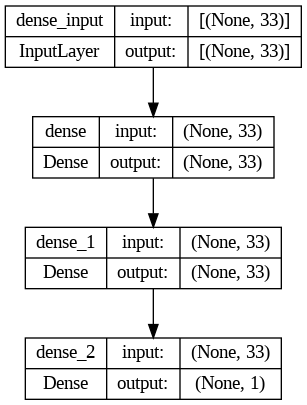

In [28]:
plot_model(model, to_file='model.png', show_shapes=True)

In [29]:
# Compile model
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=10, verbose=1)
history = model.fit(train_dataset, 
                    validation_data=val_dataset, epochs=150, callbacks=[early_stop])

Epoch 1/150
79/79 [==============================] - 2s 5ms/step - loss: 0.6655 - accuracy: 0.6146 - val_loss: 0.6220 - val_accuracy: 0.6327
Epoch 2/150
79/79 [==============================] - 0s 3ms/step - loss: 0.5747 - accuracy: 0.7170 - val_loss: 0.5861 - val_accuracy: 0.7041
Epoch 3/150
79/79 [==============================] - 0s 3ms/step - loss: 0.5236 - accuracy: 0.7465 - val_loss: 0.5538 - val_accuracy: 0.7296
Epoch 4/150
79/79 [==============================] - 0s 3ms/step - loss: 0.4834 - accuracy: 0.7964 - val_loss: 0.5251 - val_accuracy: 0.7449
Epoch 5/150
79/79 [==============================] - 0s 2ms/step - loss: 0.4493 - accuracy: 0.8195 - val_loss: 0.5085 - val_accuracy: 0.7755
Epoch 6/150
79/79 [==============================] - 0s 2ms/step - loss: 0.4173 - accuracy: 0.8438 - val_loss: 0.4842 - val_accuracy: 0.7908
Epoch 7/150
79/79 [==============================] - 0s 2ms/step - loss: 0.3918 - accuracy: 0.8566 - val_loss: 0.4648 - val_accuracy: 0.7806
Epoch 8/150
7

Evaluating the model:

In [31]:
#Evaluate model on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

7/7 [==============================] - 0s 3ms/step - loss: 0.3345 - accuracy: 0.9133
Val Loss: 0.33454903960227966
Val Accuracy: 0.9132652878761292


In [32]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 0s 2ms/step - loss: 0.3799 - accuracy: 0.8898
Test Loss: 0.3798575699329376
Test Accuracy: 0.8897958993911743


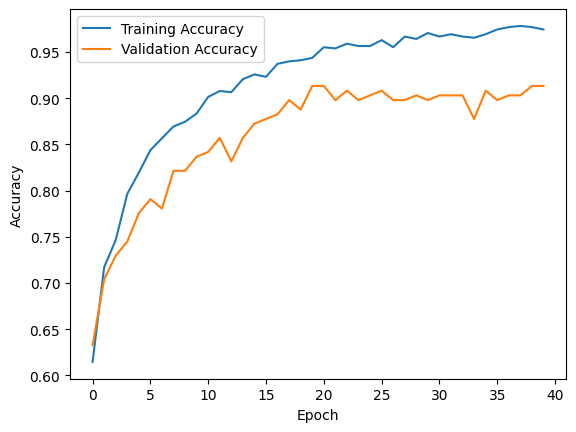

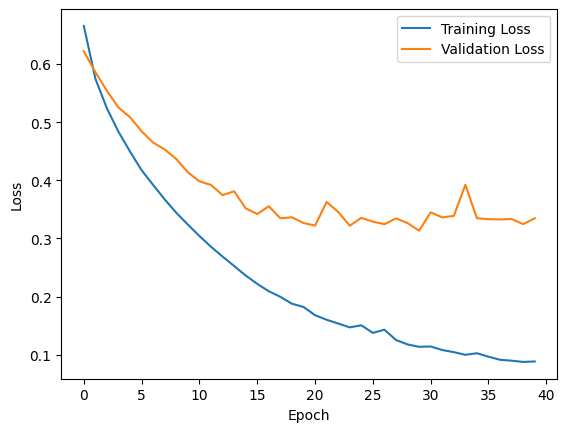

In [33]:
import matplotlib.pyplot as plt

# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## IV. Improved Network Architecture

In [55]:
# Define the model architecture
model2 = Sequential()
model2.add(Dense(512, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=keras.regularizers.l2(0.03)))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

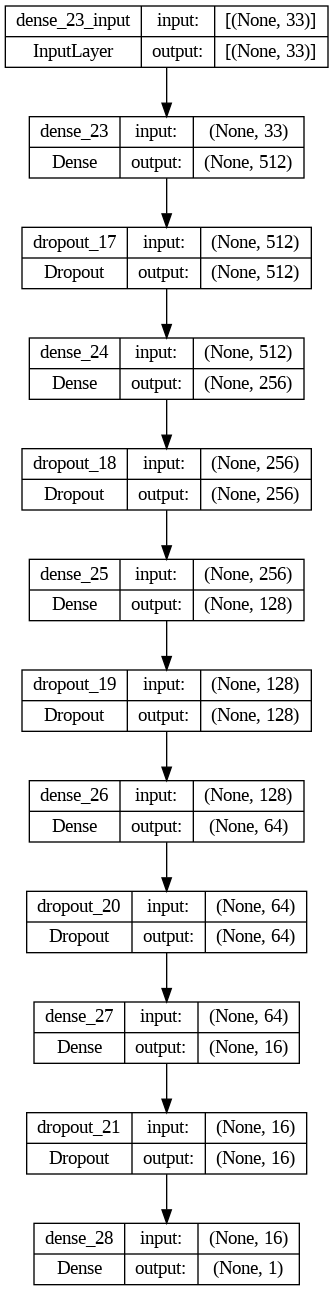

In [56]:
plot_model(model2, to_file='model.png', show_shapes=True)

In [57]:
# Compile model
model2.compile(optimizer=keras.optimizers.Adam(
    learning_rate=0.0009,
    beta_1=0.9,
    beta_2=0.999,
    epsilon= 1e-07,
    amsgrad=False,
    weight_decay= 1e-6,
    use_ema = True,
    ema_momentum = 0.99,
    ema_overwrite_frequency = 10,
    jit_compile=True,
    ),loss='binary_crossentropy', metrics=['accuracy'])

In [58]:
early_stop = EarlyStopping(patience=20, verbose=1)
history = model2.fit(train_dataset, 
                    validation_data=val_dataset, epochs=250, 
                    batch_size=10)

Epoch 1/250
79/79 [==============================] - 3s 12ms/step - loss: 2.3829 - accuracy: 0.5455 - val_loss: 2.1908 - val_accuracy: 0.6837
Epoch 2/250
79/79 [==============================] - 1s 10ms/step - loss: 2.2747 - accuracy: 0.5659 - val_loss: 2.1263 - val_accuracy: 0.7143
Epoch 3/250
79/79 [==============================] - 1s 11ms/step - loss: 2.1718 - accuracy: 0.6300 - val_loss: 2.0489 - val_accuracy: 0.7551
Epoch 4/250
79/79 [==============================] - 1s 10ms/step - loss: 2.0691 - accuracy: 0.6389 - val_loss: 1.9795 - val_accuracy: 0.7194
Epoch 5/250
79/79 [==============================] - 1s 7ms/step - loss: 1.9826 - accuracy: 0.6569 - val_loss: 1.9074 - val_accuracy: 0.7551
Epoch 6/250
79/79 [==============================] - 1s 7ms/step - loss: 1.8984 - accuracy: 0.7055 - val_loss: 1.8510 - val_accuracy: 0.7500
Epoch 7/250
79/79 [==============================] - 1s 7ms/step - loss: 1.8131 - accuracy: 0.6914 - val_loss: 1.7881 - val_accuracy: 0.7449
Epoch 8/2

## V. Model Evaluation

In [59]:
#Evaluate model on validation set
val_loss, val_acc = model2.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

7/7 [==============================] - 0s 4ms/step - loss: 0.3715 - accuracy: 0.9235
Val Loss: 0.3714861273765564
Val Accuracy: 0.9234693646430969


In [60]:
nn_accuracy_test = max(history.history['val_accuracy'])
print("Test Accuracy is:",nn_accuracy_test)

Test Accuracy is: 0.9489796161651611


In [61]:
# Evaluate model on test set
test_loss, test_acc = model2.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 0s 5ms/step - loss: 0.4868 - accuracy: 0.8980
Test Loss: 0.48678481578826904
Test Accuracy: 0.8979591727256775


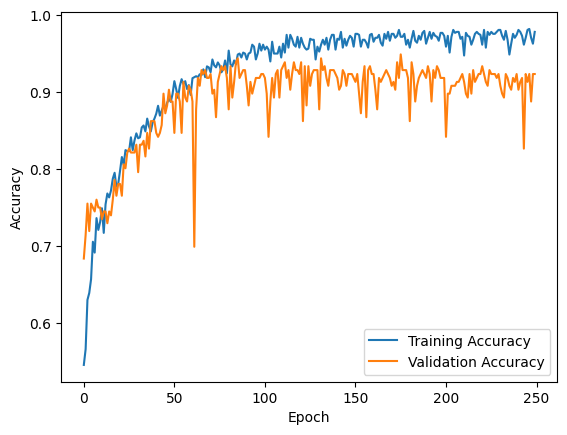

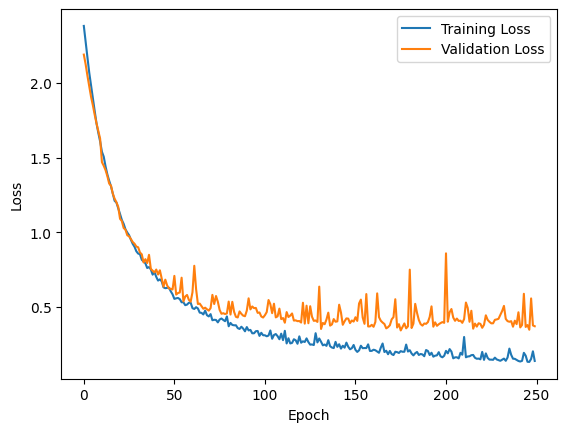

In [62]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [63]:
import numpy as np 

y_pred = model2.predict(X_test)

y_pred = np.round(y_pred)

8/8 [==============================] - 0s 2ms/step


In [64]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89       125
           1       0.84      0.98      0.90       120

    accuracy                           0.90       245
   macro avg       0.91      0.90      0.90       245
weighted avg       0.91      0.90      0.90       245



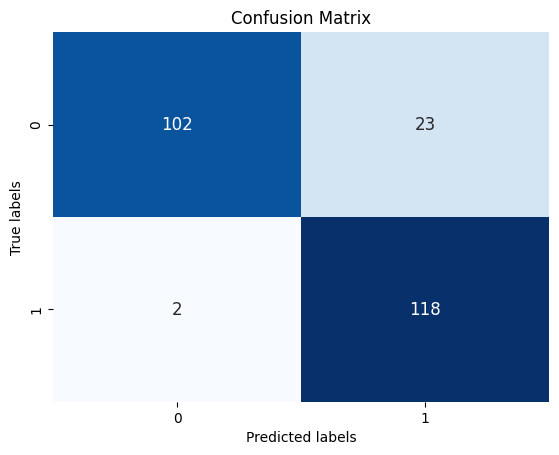

In [65]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"fontsize":12})

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

Misclassification Rate = 0.1020

#Autism Spectrum: Adolescent

In [229]:
# Import Data
df = pd.read_csv('/content/adol_dataset_clean.csv')

## I. Data Preprocessing 

In [230]:
# Checking for the target variable distribution
fig = px.pie(data_frame = df, names = 'austim', hole = 0.5, title = 'Yes vs No', 
             width = 640, height = 480, color_discrete_sequence = px.colors.sequential.Bluered)
fig.update_layout(title_x = 0.5, uniformtext_minsize = 30)
fig.show()

<ipython-input-231-93ddb8500e40>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



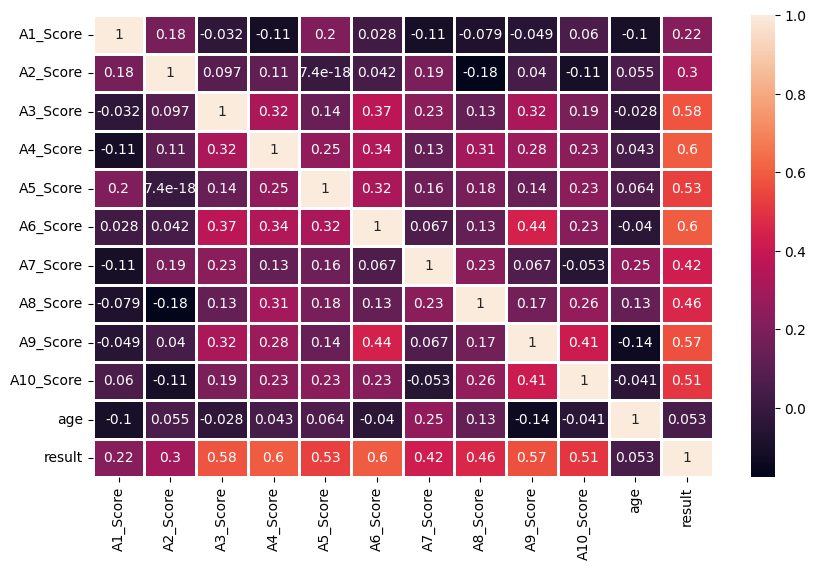

In [231]:
#Correlation plot
plt.figure(figsize = (10, 6))

corr = df.corr()

sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

In [67]:
df = df.dropna(subset=['age'])
df['austim'] = df['austim'].map({'yes': 1, 'no': 0})

In [68]:
# Check for missing values
missing_values = df.isnull().sum()

print(missing_values)

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
result             0
age_desc           0
relation           0
Class/ASD          0
dtype: int64


In [69]:
# Specify the column and the string to count
column_name = ['ethnicity', 'relation','age']
string_to_count = '?'

# Count the occurrences of the string in the column
for i in column_name:
  count = (df[i] == string_to_count).sum()
  print(count)

0
0
0


In [70]:
column_name = 'ethnicity'
column_name2 = 'relation'

mode_value = df[column_name].mode()[0]
mode_value2 = df[column_name].mode()[0]

# Replace the specific string with the mode of the column
df.ethnicity = df.ethnicity.replace('?', mode_value)
df.age = df.age.replace('?', mode_value)
df.relation = df.relation.replace('others', 'Others')
df.ethnicity = df.ethnicity.replace('others', 'Others')
df.relation = df.relation.replace('?', mode_value)
df.ethnicity = df.ethnicity.replace("'Middle Eastern '", 'Middle Eastern' )
df.ethnicity = df.ethnicity.replace('Middle Eastern ','Middle Eastern')
df.ethnicity = df.ethnicity.replace("'South Asian'",'South Asian')
df.relation = df.relation.replace("'Health care professional'", 'Health care professional')
df.relation = df.relation.replace('self', 'Self')
df.age_desc = df.age_desc.replace("'12-15 years'", "'12-16 years'")

In [71]:
# Split the dataset into features and target variable
X = df.drop('austim', axis=1)
y = df['austim']

In [72]:
X = X.drop(columns=['age','result','contry_of_res','Class/ASD'])

In [73]:
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['ethnicity','relation','gender','jundice','used_app_before','age_desc'])

In [74]:
X = X.astype(int)

In [75]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   A1_Score                           104 non-null    int64
 1   A2_Score                           104 non-null    int64
 2   A3_Score                           104 non-null    int64
 3   A4_Score                           104 non-null    int64
 4   A5_Score                           104 non-null    int64
 5   A6_Score                           104 non-null    int64
 6   A7_Score                           104 non-null    int64
 7   A8_Score                           104 non-null    int64
 8   A9_Score                           104 non-null    int64
 9   A10_Score                          104 non-null    int64
 10  ethnicity_Asian                    104 non-null    int64
 11  ethnicity_Black                    104 non-null    int64
 12  ethnicity_Hispanic    

In [76]:
# Random-Oversampling

a1=X
b1=y

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="minority")

X, y = ros.fit_resample(a1, b1)

X.shape[0] - a1.shape[0]

76

## II. Standardizing and Splitting the Dataset


In [77]:
# Scale the input features
scaler = StandardScaler()
#X = scaler.fit_transform(X)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [78]:
# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [79]:
# Convert the datasets to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [80]:
# Batch and shuffle the datasets
batch_size = 10
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## III. Base Neural Network Model

In [81]:
#Input Size
X_train.shape[1]

31

In [82]:
# Define the model architecture
model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

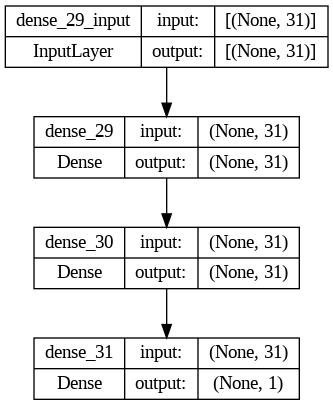

In [83]:
plot_model(model, to_file='model.png', show_shapes=True)

In [84]:
# Compile model
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [85]:
early_stop = EarlyStopping(patience=10, verbose=1)
history = model.fit(train_dataset, 
                    validation_data=val_dataset, epochs=150, callbacks=[early_stop])

Epoch 1/150
12/12 [==============================] - 1s 17ms/step - loss: 0.7557 - accuracy: 0.4696 - val_loss: 0.7069 - val_accuracy: 0.5172
Epoch 2/150
12/12 [==============================] - 0s 5ms/step - loss: 0.6750 - accuracy: 0.5826 - val_loss: 0.6623 - val_accuracy: 0.6552
Epoch 3/150
12/12 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.7043 - val_loss: 0.6226 - val_accuracy: 0.6207
Epoch 4/150
12/12 [==============================] - 0s 4ms/step - loss: 0.5758 - accuracy: 0.7478 - val_loss: 0.5945 - val_accuracy: 0.6897
Epoch 5/150
12/12 [==============================] - 0s 3ms/step - loss: 0.5381 - accuracy: 0.8174 - val_loss: 0.5713 - val_accuracy: 0.7586
Epoch 6/150
12/12 [==============================] - 0s 3ms/step - loss: 0.5019 - accuracy: 0.8783 - val_loss: 0.5493 - val_accuracy: 0.7586
Epoch 7/150
12/12 [==============================] - 0s 3ms/step - loss: 0.4679 - accuracy: 0.8957 - val_loss: 0.5277 - val_accuracy: 0.7586
Epoch 8/150


Evaluating the model

In [86]:
#Evaluate model on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

1/1 [==============================] - 0s 351ms/step - loss: 0.2339 - accuracy: 0.8966
Val Loss: 0.23389320075511932
Val Accuracy: 0.8965517282485962


In [87]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2/2 [==============================] - 0s 8ms/step - loss: 0.1214 - accuracy: 0.8889
Test Loss: 0.12138599902391434
Test Accuracy: 0.8888888955116272


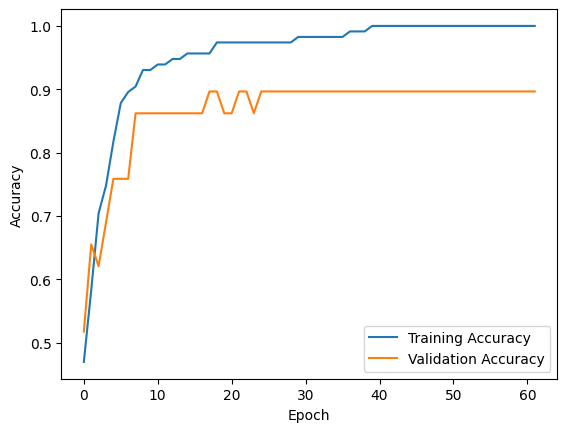

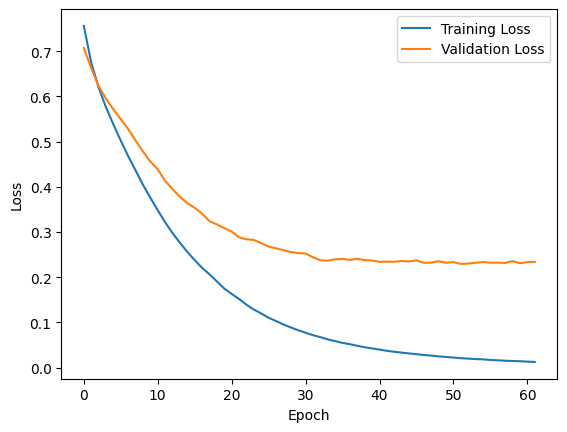

In [88]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## IV. Improved Network Architecture 

In [89]:
# Define the model architecture
model2 = Sequential()
model2.add(Dense(31, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=keras.regularizers.l2(0.03)))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

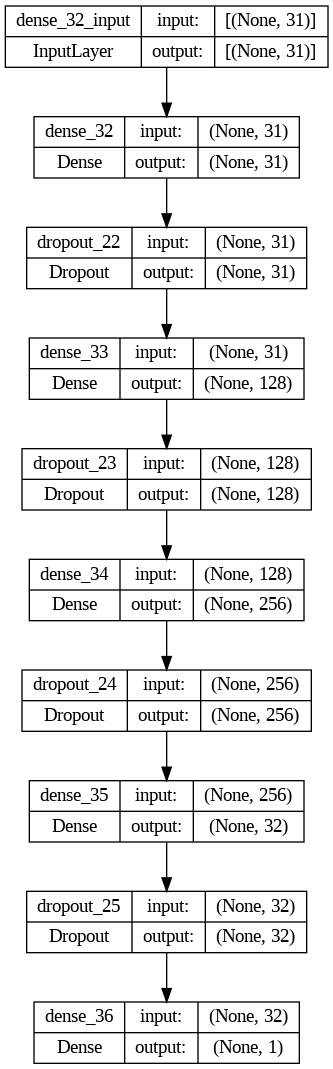

In [91]:
plot_model(model2, to_file='model.png', show_shapes=True)

In [92]:
# Compile model
model2.compile(optimizer=keras.optimizers.Adam(
    learning_rate=0.0004,
    beta_1=0.9,
    beta_2=0.999,
    epsilon= 1e-07,
    amsgrad=False,
    weight_decay= 1e-6,
    use_ema = True,
    ema_momentum = 0.8,
    ema_overwrite_frequency = 10,
    jit_compile=True,
    ),loss='binary_crossentropy', metrics=['accuracy'])

In [93]:
early_stop = EarlyStopping(patience=20, verbose=1)
history = model2.fit(train_dataset, 
                    validation_data=val_dataset, epochs=250, 
                    batch_size=8)

Epoch 1/250
12/12 [==============================] - 9s 111ms/step - loss: 1.5816 - accuracy: 0.4957 - val_loss: 1.5442 - val_accuracy: 0.8276
Epoch 2/250
12/12 [==============================] - 0s 20ms/step - loss: 1.5559 - accuracy: 0.5391 - val_loss: 1.5050 - val_accuracy: 0.9310
Epoch 3/250
12/12 [==============================] - 0s 33ms/step - loss: 1.5155 - accuracy: 0.5913 - val_loss: 1.4747 - val_accuracy: 0.7241
Epoch 4/250
12/12 [==============================] - 0s 21ms/step - loss: 1.4759 - accuracy: 0.6696 - val_loss: 1.4424 - val_accuracy: 0.7241
Epoch 5/250
12/12 [==============================] - 0s 15ms/step - loss: 1.4369 - accuracy: 0.6783 - val_loss: 1.4242 - val_accuracy: 0.7586
Epoch 6/250
12/12 [==============================] - 0s 15ms/step - loss: 1.4254 - accuracy: 0.6435 - val_loss: 1.3953 - val_accuracy: 0.7241
Epoch 7/250
12/12 [==============================] - 0s 14ms/step - loss: 1.3939 - accuracy: 0.6522 - val_loss: 1.3662 - val_accuracy: 0.7241
Epoch

## V. Model Evaluation

In [94]:
#Evaluate model on validation set
val_loss, val_acc = model2.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

1/1 [==============================] - 0s 390ms/step - loss: 0.3924 - accuracy: 0.9655
Val Loss: 0.3923812508583069
Val Accuracy: 0.9655172228813171


In [96]:
# Evaluate model on test set
test_loss, test_acc = model2.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2/2 [==============================] - 0s 8ms/step - loss: 0.1402 - accuracy: 0.9722
Test Loss: 0.14022938907146454
Test Accuracy: 0.9722222089767456


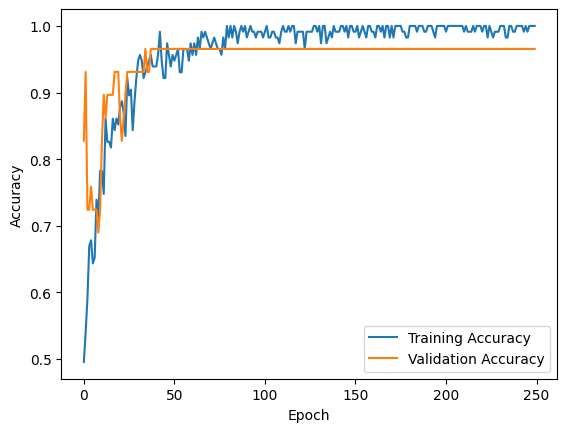

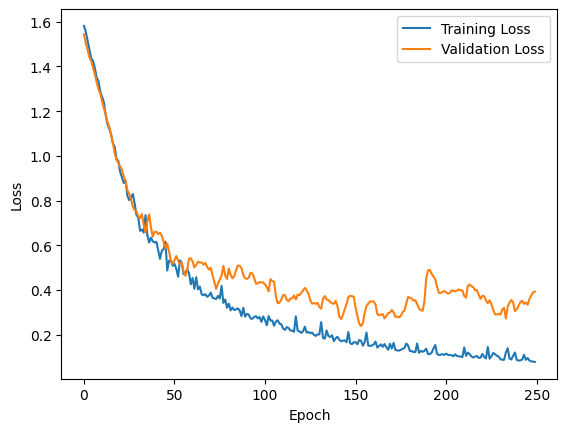

In [97]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [98]:
y_pred = model2.predict(X_test)
y_pred = np.round(y_pred)

2/2 [==============================] - 0s 5ms/step


In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.95      1.00      0.97        18

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



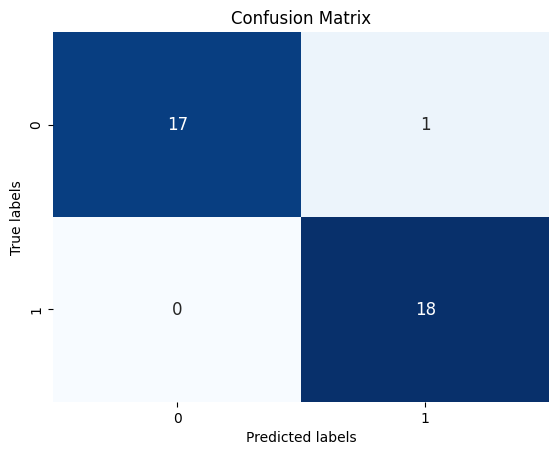

In [100]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"fontsize":12})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

Misclassification Rate = 0.0278

#Autism Spectrum: Toddlers

In [232]:
# Import Data
df = pd.read_csv('/content/child_dataset_clean.csv')

## I. Data Preprocessing

In [233]:
# Checking for the target variable distribution
fig = px.pie(data_frame = df, names = 'austim', hole = 0.5, title = 'Yes vs No', 
             width = 640, height = 480, color_discrete_sequence = px.colors.sequential.Bluered)
fig.update_layout(title_x = 0.5, uniformtext_minsize = 30)
fig.show()

<ipython-input-234-93ddb8500e40>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



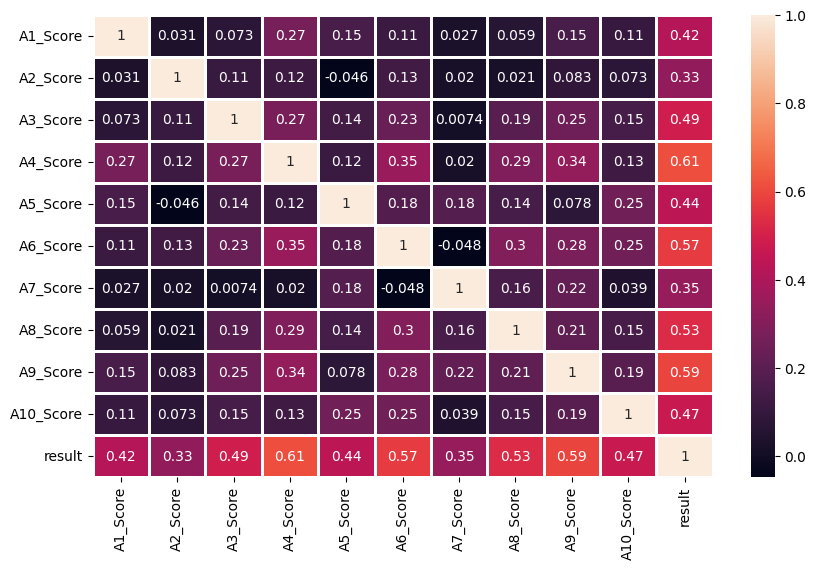

In [234]:
#Correlation plot
plt.figure(figsize = (10, 6))

corr = df.corr()

sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

In [102]:
df = df.dropna(subset=['age'])
df['austim'] = df['austim'].map({'yes': 1, 'no': 0})

In [103]:
# Check for missing values
missing_values = df.isnull().sum()

print(missing_values)

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
result             0
age_desc           0
relation           0
Class/ASD          0
dtype: int64


In [104]:
# Specify the column and the string to count
column_name = ['ethnicity', 'relation','age']
string_to_count = '?'

# Count the occurrences of the string in the column
for i in column_name:
  count = (df[i] == string_to_count).sum()
  print(count)

0
0
4


In [105]:
column_name = 'ethnicity'
column_name2 = 'relation'

mode_value = df[column_name].mode()[0]
mode_value2 = df[column_name].mode()[0]

# Replace the specific string with the mode of the column
df.ethnicity = df.ethnicity.replace('?', mode_value)
df.age = df.age.replace('?', mode_value)
df.relation = df.relation.replace('others', 'Others')
df.ethnicity = df.ethnicity.replace('others', 'Others')
df.relation = df.relation.replace('?', mode_value)
df.ethnicity = df.ethnicity.replace("'Middle Eastern '", 'Middle Eastern' )
df.ethnicity = df.ethnicity.replace('Middle Eastern ','Middle Eastern')
df.ethnicity = df.ethnicity.replace("'South Asian'",'South Asian')
df.relation = df.relation.replace("'Health care professional'", 'Health care professional')
df.relation = df.relation.replace('self', 'Self')
df.age_desc = df.age_desc.replace("'12-15 years'", "'12-16 years'")

In [106]:
# Split the dataset into features and target variable
X = df.drop('austim', axis=1)
y = df['austim']

In [107]:
X = X.drop(columns=['age','result','contry_of_res','Class/ASD'])

In [108]:
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['ethnicity','relation','gender','jundice','used_app_before','age_desc'])

In [109]:
X = X.astype(int)

In [110]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   A1_Score                           292 non-null    int64
 1   A2_Score                           292 non-null    int64
 2   A3_Score                           292 non-null    int64
 3   A4_Score                           292 non-null    int64
 4   A5_Score                           292 non-null    int64
 5   A6_Score                           292 non-null    int64
 6   A7_Score                           292 non-null    int64
 7   A8_Score                           292 non-null    int64
 8   A9_Score                           292 non-null    int64
 9   A10_Score                          292 non-null    int64
 10  ethnicity_Asian                    292 non-null    int64
 11  ethnicity_Black                    292 non-null    int64
 12  ethnicity_Hispanic    

In [111]:
# Random-Oversampling

a1=X
b1=y

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="minority")

X, y = ros.fit_resample(a1, b1)

X.shape[0] - a1.shape[0]

194

## II. Standardizing and Splitting the Dataset

In [112]:
# Scale the input features
scaler = StandardScaler()
#X = scaler.fit_transform(X)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [113]:
# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [114]:
# Convert the datasets to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [115]:
# Batch and shuffle the datasets
batch_size = 10
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## III. Base Neural Network Model

In [116]:
#Input Size
X_train.shape[1]

32

In [117]:
# Define the model architecture
model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

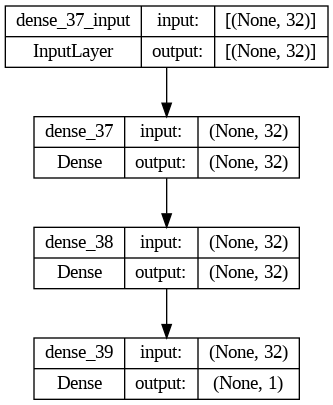

In [118]:
plot_model(model, to_file='model.png', show_shapes=True)

In [119]:
# Compile model
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [120]:
early_stop = EarlyStopping(patience=10, verbose=1)
history = model.fit(train_dataset, 
                    validation_data=val_dataset, epochs=150, callbacks=[early_stop])

Epoch 1/150
31/31 [==============================] - 1s 7ms/step - loss: 0.6959 - accuracy: 0.5677 - val_loss: 0.6389 - val_accuracy: 0.6410
Epoch 2/150
31/31 [==============================] - 0s 3ms/step - loss: 0.6114 - accuracy: 0.6677 - val_loss: 0.6188 - val_accuracy: 0.6282
Epoch 3/150
31/31 [==============================] - 0s 3ms/step - loss: 0.5680 - accuracy: 0.7355 - val_loss: 0.5973 - val_accuracy: 0.6538
Epoch 4/150
31/31 [==============================] - 0s 4ms/step - loss: 0.5303 - accuracy: 0.7645 - val_loss: 0.5849 - val_accuracy: 0.6538
Epoch 5/150
31/31 [==============================] - 0s 4ms/step - loss: 0.4988 - accuracy: 0.7742 - val_loss: 0.5795 - val_accuracy: 0.6410
Epoch 6/150
31/31 [==============================] - 0s 4ms/step - loss: 0.4750 - accuracy: 0.7806 - val_loss: 0.5691 - val_accuracy: 0.6538
Epoch 7/150
31/31 [==============================] - 0s 3ms/step - loss: 0.4490 - accuracy: 0.7935 - val_loss: 0.5595 - val_accuracy: 0.6667
Epoch 8/150
3

Evaluating the model

In [121]:
#Evaluate model on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

3/3 [==============================] - 0s 7ms/step - loss: 0.3124 - accuracy: 0.9103
Val Loss: 0.3124164640903473
Val Accuracy: 0.9102563858032227


In [122]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

4/4 [==============================] - 0s 4ms/step - loss: 0.2682 - accuracy: 0.9184
Test Loss: 0.2682366967201233
Test Accuracy: 0.918367326259613


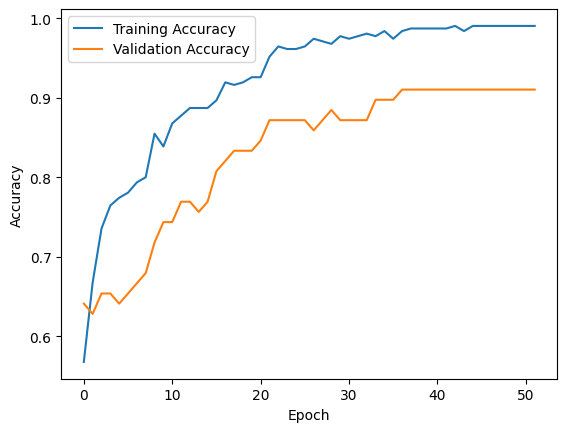

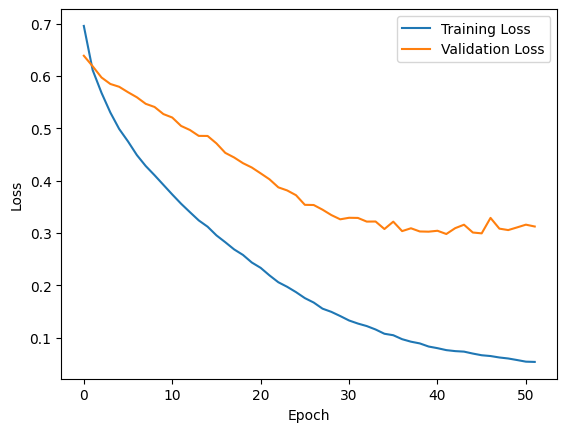

In [123]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## IV. Improved Network Architecture

In [124]:
# Define the model architecture
model2 = Sequential()
model2.add(Dense(32, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=keras.regularizers.l2(0.01)))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

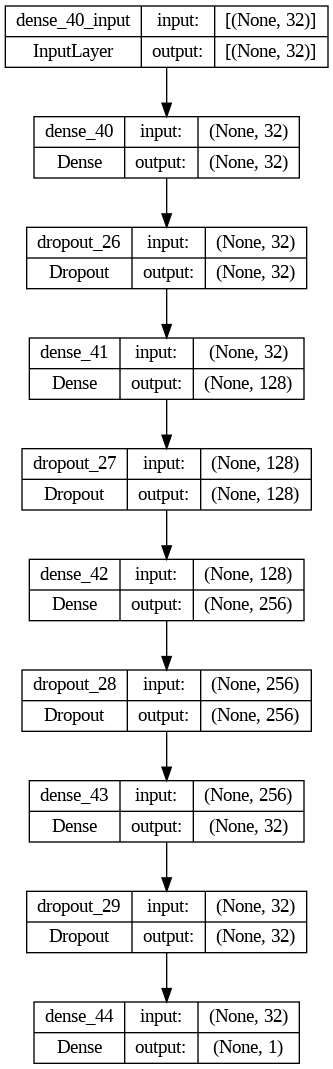

In [125]:
plot_model(model2, to_file='model.png', show_shapes=True)

In [126]:
# Compile model
model2.compile(optimizer=keras.optimizers.Adam(
    learning_rate=0.0008,
    beta_1=0.9,
    beta_2=0.999,
    epsilon= 1e-07,
    amsgrad=False,
    weight_decay= 1e-6,
    use_ema = True,
    ema_momentum = 0.9,
    ema_overwrite_frequency = 10,
    jit_compile=True,
    ),loss='binary_crossentropy', metrics=['accuracy'])

In [127]:
early_stop = EarlyStopping(patience=20, verbose=1)
history = model2.fit(train_dataset, 
                    validation_data=test_dataset, epochs=200, 
                    batch_size=16)

Epoch 1/200
31/31 [==============================] - 2s 9ms/step - loss: 1.0179 - accuracy: 0.4839 - val_loss: 1.0108 - val_accuracy: 0.4286
Epoch 2/200
31/31 [==============================] - 0s 4ms/step - loss: 0.9840 - accuracy: 0.5452 - val_loss: 0.9877 - val_accuracy: 0.4490
Epoch 3/200
31/31 [==============================] - 0s 4ms/step - loss: 0.9475 - accuracy: 0.5871 - val_loss: 0.9633 - val_accuracy: 0.5204
Epoch 4/200
31/31 [==============================] - 0s 4ms/step - loss: 0.9057 - accuracy: 0.6290 - val_loss: 0.9343 - val_accuracy: 0.5816
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.8814 - accuracy: 0.6548 - val_loss: 0.9137 - val_accuracy: 0.6020
Epoch 6/200
31/31 [==============================] - 0s 4ms/step - loss: 0.8532 - accuracy: 0.6839 - val_loss: 0.8990 - val_accuracy: 0.5102
Epoch 7/200
31/31 [==============================] - 0s 4ms/step - loss: 0.8167 - accuracy: 0.7290 - val_loss: 0.8678 - val_accuracy: 0.7041
Epoch 8/200
3

## V. Model Evaluation

In [128]:
#Evaluate model on validation set
val_loss, val_acc = model2.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

3/3 [==============================] - 0s 5ms/step - loss: 0.5545 - accuracy: 0.9103
Val Loss: 0.5544634461402893
Val Accuracy: 0.9102563858032227


In [129]:
nn_accuracy_test = max(history.history['val_accuracy'])
print("Test Accuracy is:",nn_accuracy_test)

Test Accuracy is: 0.9387755393981934


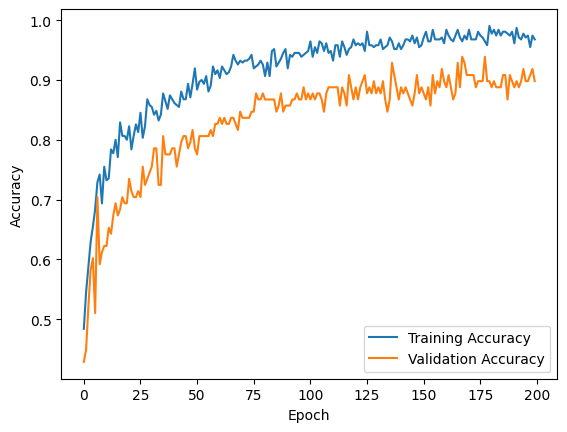

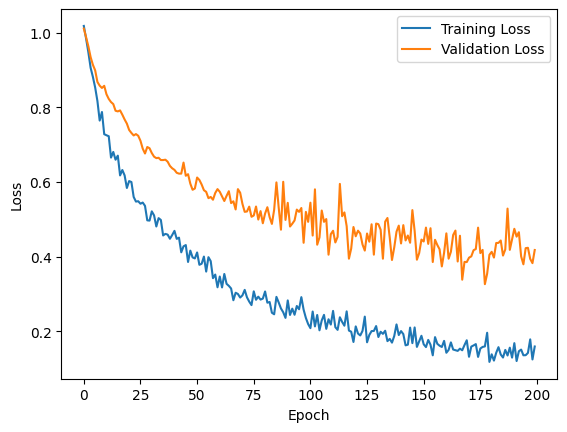

In [131]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [132]:
y_pred = model2.predict(X_test)
y_pred = np.round(y_pred)

4/4 [==============================] - 0s 4ms/step


In [133]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87        44
           1       0.84      1.00      0.92        54

    accuracy                           0.90        98
   macro avg       0.92      0.89      0.89        98
weighted avg       0.91      0.90      0.90        98



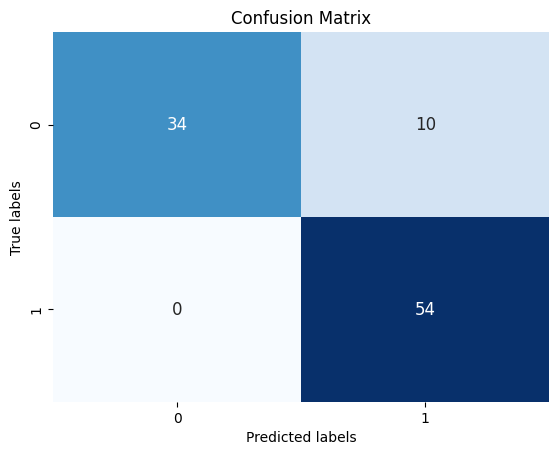

In [134]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"fontsize":12})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

Misclassification Rate = 0.1020

#Combined Age Group: Autism Spectrum Screening 

In [235]:
import pandas as pd

# Load the datasets
df1 = pd.read_csv('/content/autism_screening.csv')
df2 = pd.read_csv('/content/adol_dataset_clean.csv')
df3 = pd.read_csv('/content/child_dataset_clean.csv')

# Concatenate the datasets vertically
df = pd.concat([df1, df2, df3], axis=0)

# Reset the index of the concatenated DataFrame
df = df.reset_index(drop=True)

## I. Data Preprocessing

In [236]:
# Checking for the target variable distribution
fig = px.pie(data_frame = df, names = 'austim', hole = 0.5, title = 'Yes vs No', 
             width = 640, height = 480, color_discrete_sequence = px.colors.sequential.Bluered)
fig.update_layout(title_x = 0.5, uniformtext_minsize = 30)
fig.show()

<ipython-input-237-93ddb8500e40>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



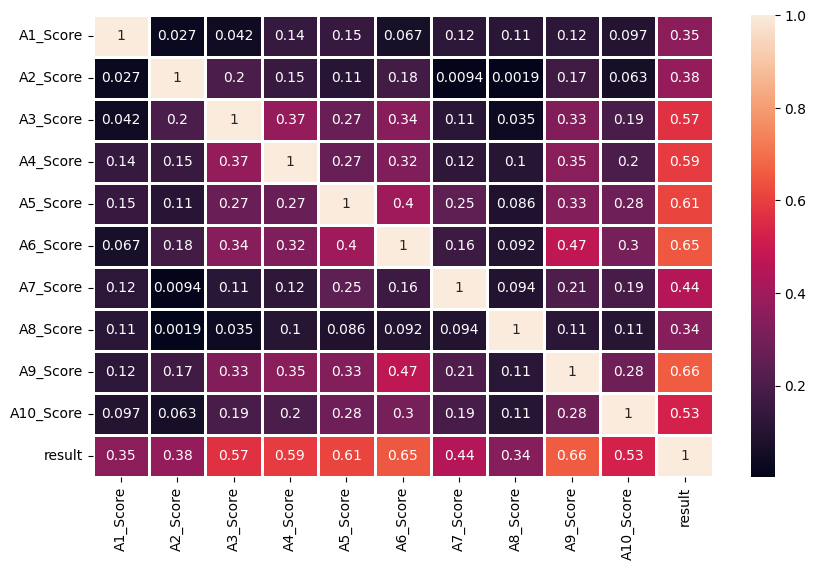

In [237]:
#Correlation plot
plt.figure(figsize = (10, 6))

corr = df.corr()

sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

In [188]:
df = df.dropna(subset=['age'])

In [189]:
df['austim'] = df['austim'].map({'yes': 1, 'no': 0})

In [190]:
# Check for missing values
missing_values = df.isnull().sum()

print(missing_values)

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
result             0
age_desc           0
relation           0
Class/ASD          0
dtype: int64


In [191]:
# Specify the column and the string to count
column_name = ['ethnicity', 'relation','age']
string_to_count = '?'

# Count the occurrences of the string in the column
for i in column_name:
  count = (df[i] == string_to_count).sum()
  print(count)

93
93
4


In [192]:
column_name = 'ethnicity'
column_name2 = 'relation'

mode_value = df[column_name].mode()[0]
mode_value2 = df[column_name].mode()[0]

# Replace the specific string with the mode of the column
df.ethnicity = df.ethnicity.replace('?', mode_value)
df.age = df.age.replace('?', mode_value)
df.relation = df.relation.replace('others', 'Others')
df.ethnicity = df.ethnicity.replace('others', 'Others')
df.relation = df.relation.replace('?', mode_value)
df.ethnicity = df.ethnicity.replace("'Middle Eastern '", 'Middle Eastern' )
df.ethnicity = df.ethnicity.replace('Middle Eastern ','Middle Eastern')
df.ethnicity = df.ethnicity.replace("'South Asian'",'South Asian')
df.relation = df.relation.replace("'Health care professional'", 'Health care professional')
df.relation = df.relation.replace('self', 'Self')
df.age_desc = df.age_desc.replace("'12-15 years'", "'12-16 years'")

In [193]:
# Split the dataset into features and target variable
X = df.drop('austim', axis=1)
y = df['austim']

In [194]:
X = X.drop(columns=['age','result','contry_of_res','Class/ASD'])

In [195]:
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['ethnicity','relation','gender','jundice','used_app_before','age_desc'])

In [196]:
X = X.astype(int)

In [197]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 0 to 1099
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   A1_Score                           1098 non-null   int64
 1   A2_Score                           1098 non-null   int64
 2   A3_Score                           1098 non-null   int64
 3   A4_Score                           1098 non-null   int64
 4   A5_Score                           1098 non-null   int64
 5   A6_Score                           1098 non-null   int64
 6   A7_Score                           1098 non-null   int64
 7   A8_Score                           1098 non-null   int64
 8   A9_Score                           1098 non-null   int64
 9   A10_Score                          1098 non-null   int64
 10  ethnicity_Asian                    1098 non-null   int64
 11  ethnicity_Black                    1098 non-null   int64
 12  ethnicity_Hispanic  

In [198]:
# Random-Oversampling

a1=X
b1=y

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="minority")

X, y = ros.fit_resample(a1, b1)

X.shape[0] - a1.shape[0]

790

## II. Standardizing and Splitting the Dataset

In [199]:
# Scale the input features
scaler = StandardScaler()
#X = scaler.fit_transform(X)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [200]:
# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [201]:
# Convert the datasets to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [202]:
# Batch and shuffle the datasets
batch_size = 10
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## III. Base Neural Network Model

In [203]:
#Input Size
X_train.shape[1]

35

In [204]:
# Define the model architecture
model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

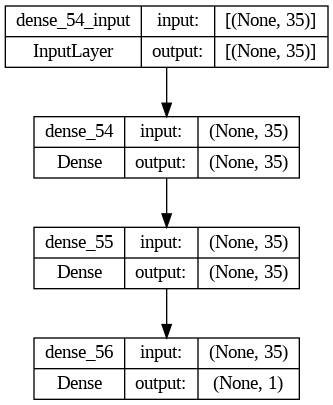

In [205]:
plot_model(model, to_file='model.png', show_shapes=True)

In [206]:
# Compile model
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [207]:
early_stop = EarlyStopping(patience=10, verbose=1)
history = model.fit(train_dataset, 
                    validation_data=val_dataset, epochs=150, callbacks=[early_stop])

Epoch 1/150
121/121 [==============================] - 2s 5ms/step - loss: 0.6451 - accuracy: 0.6233 - val_loss: 0.6504 - val_accuracy: 0.6159
Epoch 2/150
121/121 [==============================] - 0s 3ms/step - loss: 0.5745 - accuracy: 0.7012 - val_loss: 0.6257 - val_accuracy: 0.6556
Epoch 3/150
121/121 [==============================] - 0s 3ms/step - loss: 0.5336 - accuracy: 0.7401 - val_loss: 0.6041 - val_accuracy: 0.6755
Epoch 4/150
121/121 [==============================] - 0s 3ms/step - loss: 0.4958 - accuracy: 0.7748 - val_loss: 0.5842 - val_accuracy: 0.6954
Epoch 5/150
121/121 [==============================] - 0s 3ms/step - loss: 0.4626 - accuracy: 0.7972 - val_loss: 0.5712 - val_accuracy: 0.7219
Epoch 6/150
121/121 [==============================] - 0s 3ms/step - loss: 0.4334 - accuracy: 0.8220 - val_loss: 0.5518 - val_accuracy: 0.7351
Epoch 7/150
121/121 [==============================] - 0s 4ms/step - loss: 0.4007 - accuracy: 0.8377 - val_loss: 0.5603 - val_accuracy: 0.7483

Evaluating the model

In [208]:
#Evaluate model on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

10/10 [==============================] - 0s 3ms/step - loss: 0.4897 - accuracy: 0.8841
Val Loss: 0.4896751642227173
Val Accuracy: 0.8841059803962708


In [209]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

12/12 [==============================] - 0s 3ms/step - loss: 0.3097 - accuracy: 0.8889
Test Loss: 0.30965161323547363
Test Accuracy: 0.8888888955116272


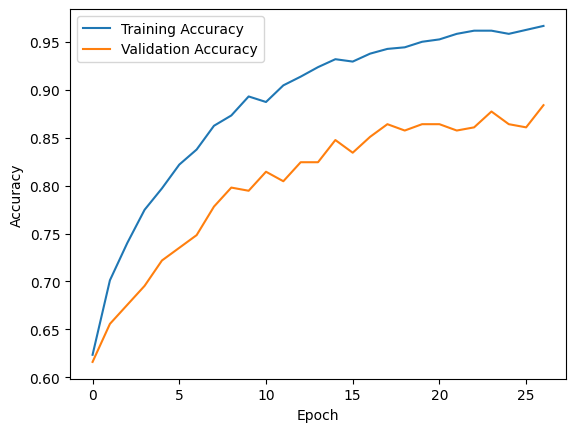

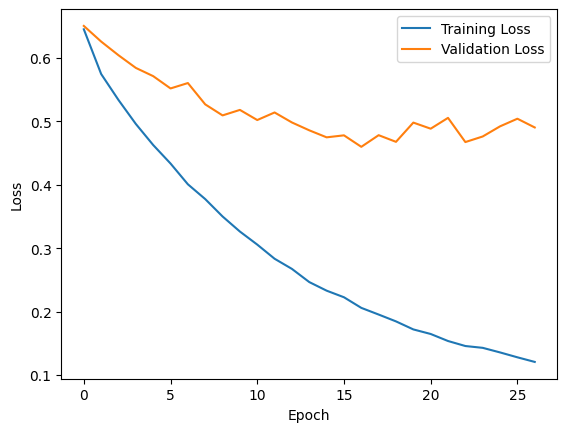

In [210]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## IV. Improved Network Architecture

In [211]:
X_train.shape[1]

35

In [212]:
# Define the model architecture
model2 = Sequential()
model2.add(Dense(512, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=keras.regularizers.l2(0.03)))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

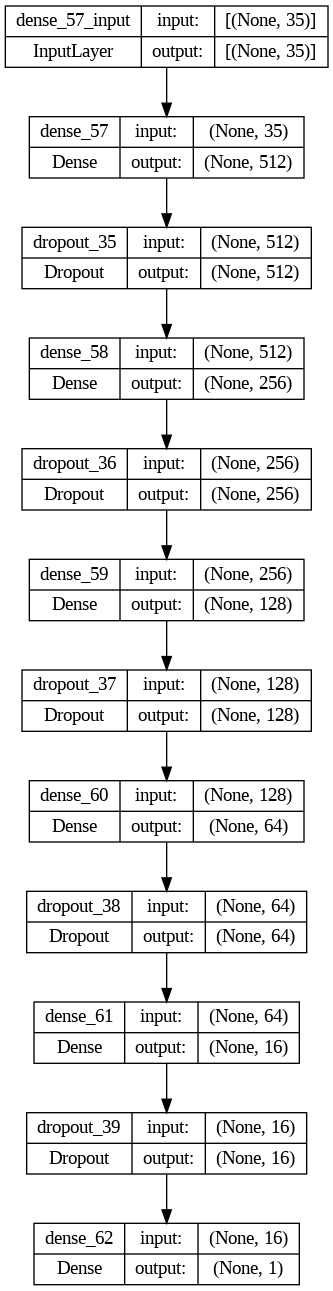

In [213]:
plot_model(model2, to_file='model.png', show_shapes=True)

In [214]:
# Compile model
model2.compile(optimizer=keras.optimizers.Adam(
    learning_rate=0.0009,
    beta_1=0.9,
    beta_2=0.999,
    epsilon= 1e-07,
    amsgrad=False,
    weight_decay= 1e-6,
    use_ema = True,
    ema_momentum = 0.99,
    ema_overwrite_frequency = 10,
    jit_compile=True,
    ),loss='binary_crossentropy', metrics=['accuracy'])

In [215]:
early_stop = EarlyStopping(patience=20, verbose=1)
history = model2.fit(train_dataset, 
                    validation_data=val_dataset, epochs=250, 
                    batch_size=10)

Epoch 1/250
121/121 [==============================] - 4s 12ms/step - loss: 2.4356 - accuracy: 0.5224 - val_loss: 2.4322 - val_accuracy: 0.5629
Epoch 2/250
121/121 [==============================] - 1s 8ms/step - loss: 2.2499 - accuracy: 0.5720 - val_loss: 2.2220 - val_accuracy: 0.5927
Epoch 3/250
121/121 [==============================] - 1s 8ms/step - loss: 2.0816 - accuracy: 0.5952 - val_loss: 2.0392 - val_accuracy: 0.6192
Epoch 4/250
121/121 [==============================] - 1s 7ms/step - loss: 1.9287 - accuracy: 0.6424 - val_loss: 1.8788 - val_accuracy: 0.6258
Epoch 5/250
121/121 [==============================] - 1s 8ms/step - loss: 1.7947 - accuracy: 0.6730 - val_loss: 1.7314 - val_accuracy: 0.6291
Epoch 6/250
121/121 [==============================] - 1s 8ms/step - loss: 1.6770 - accuracy: 0.6714 - val_loss: 1.6066 - val_accuracy: 0.6623
Epoch 7/250
121/121 [==============================] - 1s 8ms/step - loss: 1.5681 - accuracy: 0.6921 - val_loss: 1.5366 - val_accuracy: 0.602

## V. Model Evaluation

In [216]:
#Evaluate model on validation set
val_loss, val_acc = model2.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

10/10 [==============================] - 0s 3ms/step - loss: 0.4679 - accuracy: 0.8974
Val Loss: 0.46792900562286377
Val Accuracy: 0.8973509669303894


In [217]:
nn_accuracy_test = max(history.history['val_accuracy'])
print("Test Accuracy is:",nn_accuracy_test)

Test Accuracy is: 0.9105960130691528


In [218]:
# Evaluate model on test set
test_loss, test_acc = model2.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

12/12 [==============================] - 0s 3ms/step - loss: 0.4432 - accuracy: 0.8810
Test Loss: 0.44319257140159607
Test Accuracy: 0.8809523582458496


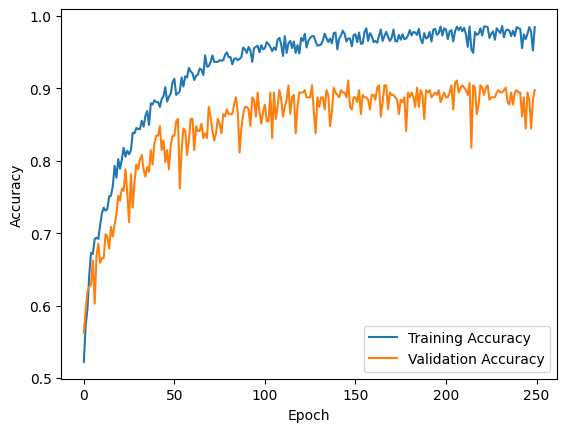

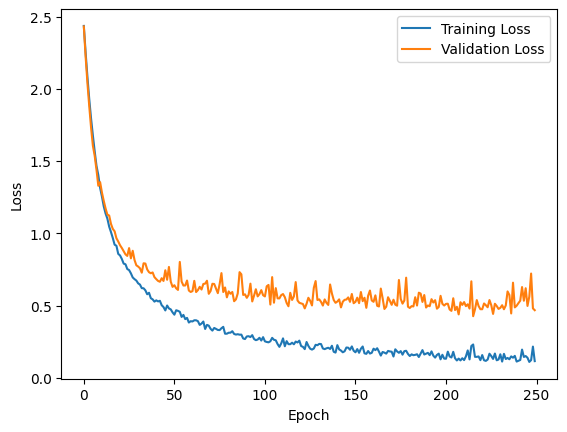

In [219]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [220]:
y_pred = model2.predict(X_test)
y_pred = np.round(y_pred)

12/12 [==============================] - 0s 2ms/step


In [221]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.78      0.86       183
           1       0.82      0.98      0.89       195

    accuracy                           0.88       378
   macro avg       0.90      0.88      0.88       378
weighted avg       0.90      0.88      0.88       378



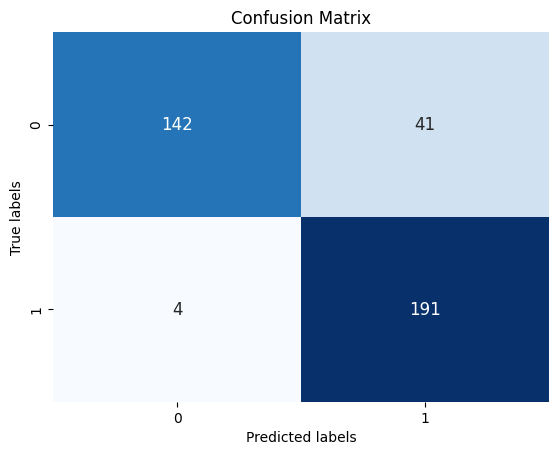

In [222]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"fontsize":12})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

Misclassification Rate = 0.1190

# Summary

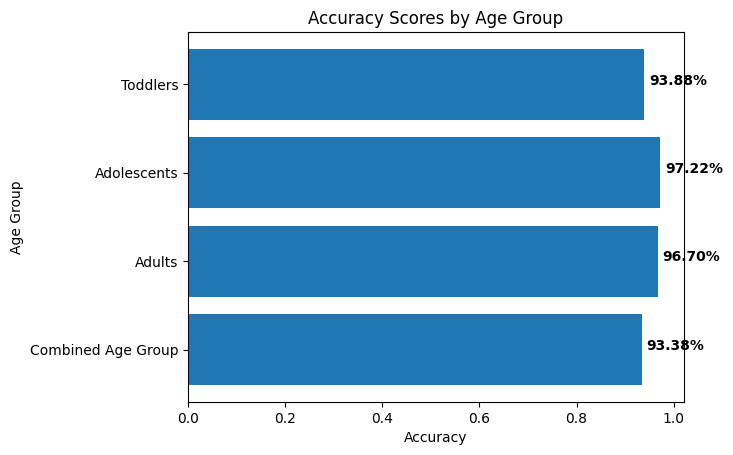

In [245]:
# Define x and y data
x = ['Toddlers', 'Adolescents', 'Adults', 'Combined Age Group']
y = [0.93877, 0.9722, 0.9670, 0.9338]

# Create a horizontal bar plot
fig, ax = plt.subplots()
ax.barh(x, y)

# Invert y-axis to show categories in descending order
ax.invert_yaxis()

# Set axis labels and title
ax.set_xlabel('Accuracy')
ax.set_ylabel('Age Group')
ax.set_title('Accuracy Scores by Age Group')

# Add percentage labels to each bar
for i, v in enumerate(y):
    ax.text(v + 0.01, i, f'{v:.2%}', color='black', fontweight='bold')

# Display the plot
plt.show()


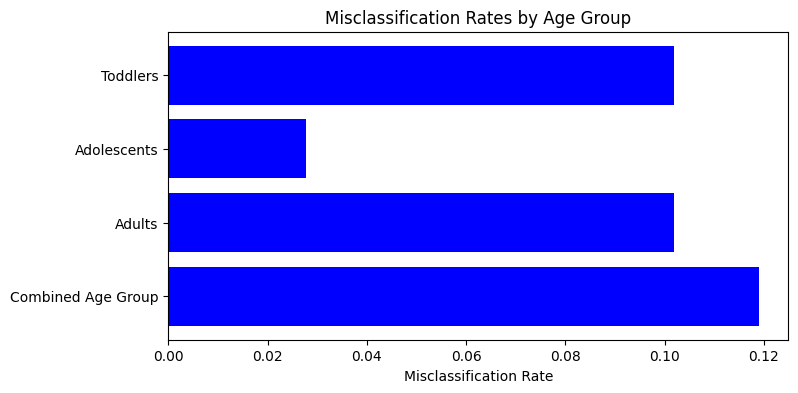

In [246]:
import matplotlib.pyplot as plt

x = ['Toddlers', 'Adolescents', 'Adults', 'Combined Age Group']
y = [0.1020, 0.0278, 0.1020, 0.1190]
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(x, y, align='center', color='blue')
ax.set_xlabel('Misclassification Rate')
ax.set_title('Misclassification Rates by Age Group')
ax.invert_yaxis()
plt.show()